In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Let's load in the data. Each file will have its own dataframe.
item_categories = pd.read_csv('data/item_categories.csv')
items           = pd.read_csv('data/items.csv')
shops           = pd.read_csv('data/shops.csv')

train           = pd.read_csv('data/sales_train.csv')
test            = pd.read_csv('data/test.csv')

### Basic look through the data

We'll go through the dataframes and see what's inside them.

In [3]:
# And now it is time for some exploration.

# Item categories just contains category names in item_category_name and their ids in item_category_id.
# Nothing crazy.
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [4]:
# Let's look at items a bit.
# item_name        has, well, the name of the item.
# item_id          gives each item their unique id.
# item_category_id is an item category taken from item_categories, basically.
# You could probably replace them with the values from it and one-hot it,
# but it'll end up taking so much memory...

items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
# Let's check out shops.
# This is starting to remind me of databases a bit.
# Wonder what normal form this whole thing is in.

# Are these pairs of shops the same?
# Maybe there was some formatting error or something.
# We might want to deal with that later.
shops.iloc(0)[[0, 57, 1, 58, 10, 11]]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
57,"Якутск Орджоникидзе, 56",57
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


In [6]:
# Now for something more interesting, the contents of the training data.
# date           DD.MM.YYYY date.
# date_block_num 0...33, where Jan 2013 is 0, Feb 2013 is 1...
# shop_id        id of the shop from shops.csv
# item_id        id of the item from items.csv
# item_price     the actual price of the item! this is probably pretty variable
# item_cnt_day   number sold on this date. can be negative? possibly refunds.
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
# Item price has absurd min and max.
# 307k ruble would be something like 3.4 thousand euro.
# Maybe not that crazy, but the negative price surely is.

# Sold in the day is also a bit iffy. Negative 22 'sold' a day?
# We'll probably be better off clipping that to zero as well.
round(train.describe(), 3)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.000,2935849.000,2935849.000,2935849.000,2935849.000
mean,14.570,33.002,10197.227,890.853,1.243
std,9.423,16.227,6324.297,1729.800,2.619
min,0.000,0.000,0.000,-1.000,-22.000
25%,7.000,22.000,4476.000,249.000,1.000
50%,14.000,31.000,9343.000,399.000,1.000
75%,23.000,47.000,15684.000,999.000,1.000
max,33.000,59.000,22169.000,307980.000,2169.000


In [8]:
# What do we get in the test data?
# Nothing but ID (probably unnecessary), the shop id, and item id.
# Using these and whatever we can conjure up from them, we have to predict sales for the next month (not just day!)
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### Training set outliers

We'll try to deal with outliers in the training set now

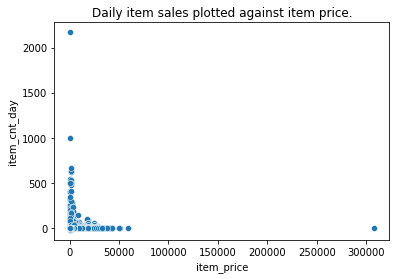

In [9]:
# Let's see if I can make a plot of the item prices and sales counts at once here.
sns.scatterplot(x = train.item_price, y = train.item_cnt_day)
plt.title('Daily item sales plotted against item price.')
plt.show()

In [10]:
# Alright, I guess we can get rid of the expensive thing after all.
# I'll drop rows in training with price above 100 grand and sales figures above 800 or so.
# Of course, negative prices and negative sales should probably be taken away as well.

train = train[(train['item_price'] >= 0) & (train['item_price'] <= 100_000)
            & (train['item_cnt_day'] >= 0) & (train['item_cnt_day'] <= 800)]

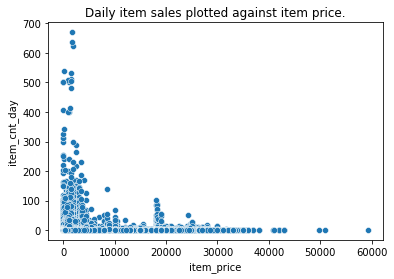

In [11]:
# Let's make the plot again!
sns.scatterplot(x = train.item_price, y = train.item_cnt_day)
plt.title('Daily item sales plotted against item price.')
plt.show()
# I like this one a lot more now.

### Killing duplicate values

As we noted before, we have duplicate shops in the data. Let's get rid of the shops with messed up looking names and just use the good ones.

That is to say, replace 0 with 57, 1 with 58, and 10 with 11.

The data sets that referenced shop id were only train and test.

In [12]:
# Let's see if we even need to do this.

for shop in [0, 57, 1, 58, 10, 11]:
    n = test[test['shop_id'] == shop].shape[0]
    k = train[train['shop_id'] == shop].shape[0]
    print(f'The amount of shops with id {shop} is {n} in the test set and {k} in the training set.')

The amount of shops with id 0 is 0 in the test set and 9857 in the training set.
The amount of shops with id 57 is 5100 in the test set and 117114 in the training set.
The amount of shops with id 1 is 0 in the test set and 5678 in the training set.
The amount of shops with id 58 is 5100 in the test set and 71268 in the training set.
The amount of shops with id 10 is 5100 in the test set and 21397 in the training set.
The amount of shops with id 11 is 0 in the test set and 499 in the training set.


In [13]:
# Well, then, time to get to replacing.
# We need to swap out 10 for 11 in the test set
# and ALL of the values in the train set.
# Might as well keep it simple and do it in a loop.

# Avoiding SettingWithCopyWarning: data.loc[data.col == 'data', 'col2'] = newval
changes = [(0, 57), (1, 58), (10, 11)]
for from_, to_ in changes:
    test.loc[test.shop_id   == from_, 'shop_id'] = to_
    train.loc[train.shop_id == from_, 'shop_id'] = to_

### Tiny bit of extra cleaning

We saw the test set have a somewhat extraneous ID column, but we need to have that in the submission file anyway. I'll see later if it stays necessary to have.

What we could get rid of are the extra shops that we have in the shops dataframe now.

In [14]:
shops = shops[(shops['shop_id'] != 0) & (shops['shop_id'] != 1) & (shops['shop_id'] != 10)]

That's the low hanging fruit gone, I guess.

### First attempt at an overly simple model

Let's now take into account just the last month. For each pair of item and shop, taking into account month number 33 (the last one), let's sum up our sales for that month, if we have any. If we do not have any, we use 0. If we have more than 20, we use 20 (for RMSE calculation in the end, higher values are clipped between 0 and 20).

In [15]:
'''
preds = []
used_subset = train[train['date_block_num'] == 33].copy()

def avg_for_last_month(data, shop, item):
    # It just does what it says on the tin.
    # Except it also maxes out at 20 sales, because true target values are clipped between 0 and 20.
    # If a value is missing completely? We revert to baseline 0.5
    filtered = data[(data['shop_id'] == shop) & (data['item_id'] == item)]
    if (filtered.shape[0] == 0):
        return 0.5
    else:
        return min(filtered.item_cnt_day.sum(), 20.0)

for row in test.iloc(axis=0):
    id_, shop, item = row.ID, row.shop_id, row.item_id
    # Using shop id and item id, push the average for the month into preds
    preds.append(avg_for_last_month(used_subset, shop, item))
''';

This takes a bit of time... Anyway, some numbers while we are here.  
The baseline submission has all predictions at 0.5. The RMSE for that is 1.23646 (which, funnily enough, already gets you into the top 78%...).  
I expect this to be maybe a SLIGHT improvement. Let's see.

In [16]:
'''
with open('bad_submission.csv', 'w') as file:
    file.write('ID,item_cnt_month\n')
    for i, pred in enumerate(preds):
        file.write(f'{i},{pred}\n')
    print('File written.')
del preds
del used_subset
''';

Using this absolute mess of a pretend model, we achieve RMSE of 1.19724! Woo-hoo, with this absolute trash we have entered the top 66%! Let's not push this any further, though, clearly we will get no results here. Maybe taking a few months of data would get us into top 50% though, hmm?

### More...

We need to figure this time series stuff out. Chances are we need to fabricate a data point for each month, for each shop, for each item. Definitely not for each day, it seems to me we'd get something like a couple hundred million rows and the information would be way too specific.

We should check if we have shops that are not present in the training/test data or items that are not present in the training/test data to reduce possible combinations. Dropping shops would have the biggest impact here.

Once we have a data set with each month, shop id, item id, the (average?) price (we'd need to impute this somehow, I think), and (summed for the month) sales (ditto), we can probably get to thinking up new features.

In [17]:
trainset = set(train.shop_id)
testset  = set(test.shop_id)

trainset == testset

False

In [18]:
# Find out what the difference is...

print(f'Train - Test: {trainset - testset}')

print(f'Test - Train: {testset - trainset}')

Train - Test: {32, 33, 8, 9, 40, 43, 13, 17, 51, 20, 54, 23, 27, 29, 30}
Test - Train: set()


Score! There are many stores which only exist inside the training set, yet are not in the 'test' set. Let's remove all of these from the training data.

In [19]:
diff = trainset - testset

In [20]:
for store in diff:
    train = train[(train['shop_id'] != store)]

Now we have half a million fewer rows, which is a sixth of the dataset! Let's try the same with items.

In [21]:
trainset = set(train.item_id)
testset  = set(test.item_id)

trainset == testset

False

In [22]:
print(len(testset))
print(len(trainset))
print(len(testset - trainset))
print(len(trainset - testset))

5100
21081
384
16365


Perhaps not. This will get rid of too much information, besides, the item id isn't all that matters...

Let's split the data into months now. Also take into account which shops and items we have anymore.

In [23]:
allitems = set(train.item_id)
allshops = set(train.shop_id)

months = sorted(list(set(train.date_block_num)))

print(f'Months in data: {months}')

Months in data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


This is just zero until thirty-three. Let's make an array and put slices of the dataframe into it.

In [24]:
months_sep = []

for month in months:
    months_sep.append(train[train['date_block_num'] == month][['shop_id', 'item_id', 'item_price', 'item_cnt_day']])

Now I will write a function that takes a dataframe for a given month and 'compresses' it in a sense, so that for each item and store, there is only one entry for the month, not for every day.

In [25]:
def compress(df):
    shops = set(df.shop_id)
    items = set(df.item_id)
    out = []
    
    for shop in list(shops)[:2]:
        for item in items:
            k = df[(df['shop_id'] == shop) & (df['item_id'] == item)] # current shop/item combo
            if len(k) == 0:
                continue
            # weighted price...
            sales = k.item_cnt_day.sum()
            avg_price = sum(map(lambda x: x[0] * x[1], zip(k.item_price, k.item_cnt_day))) / sales
            out.append([shop, item, avg_price, sales])
    
    return pd.DataFrame(out, columns = ['shop_id', 'item_id', 'item_price', 'item_cnt_month'])

In [26]:
compressed = list(map(compress, months_sep))

This takes a few minutes... And it may yet get worse, since I will have to fill it all with zero values. Maybe I will try to finesse my way through this, though.

In [27]:
len(allitems) * len(allshops) * len(compressed) # items times shops times months

30103668

Our final dataframe would have to end up having this many rows... Let's see how many we have.

In [28]:
sum(map(len, compressed))

32359

Yeah, that doesn't look too good for us.

In [29]:
len(test)

214200

In [30]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


Well, right... I'll just generate all the data, then. The vast majority of our data will be zeroes... IF this works, we'll be fine. Otherwise, we'll be very sad.

Our columns would be shop id, item id, month, price change in last month, price, sales change in last month, and finally item sales in y. Then we'll just go ahead and see how it does - probably absolutely awfully, especially given the effort - but I guess that's fine anyway. That's how you learn (NOT a coping mechanism).

In [31]:
X_train = []
y_train = []

# add two months (10 and 11) to start out with, with default values if nothing else exists.
for i in range(10, 12):
    next_X = []
    next_y = []
    curr = compressed[i]
    for shop_id, item_id in zip(test.shop_id, test.item_id):
        # populate with defaults
        k = curr[(curr['shop_id'] == shop_id) & (curr['item_id'] == item_id)]
        if (len(k) == 0): # defaults
            next_X.append([shop_id, item_id, i % 12, 0, 0, 0])
            next_y.append(0)
            continue
        # the row has some information in it (we will only have one entry anyway)
        next_X.append([shop_id, item_id, i % 12, 0, k.item_price.iloc(0)[0], 0])
        next_y.append(k.item_cnt_month.iloc(0)[0])
    X_train.append(next_X)
    y_train.append(next_y)

In [32]:
for i in range(12, len(compressed)):
    next_X = []
    next_y = []
        
    curr = compressed[i]
    prv1 = X_train[-1]
    prv2 = X_train[-2]
    # So we could index lists in next_X, an extra variable to keep track of index here.
    # This will be correct since the order of the elements in test never changes.
    ix = 0
    for shop_id, item_id in zip(test.shop_id, test.item_id):
        k = curr[(curr['shop_id'] == shop_id) & (curr['item_id'] == item_id)]
        k1 = prv1[ix] # previous month data
        k2 = prv2[ix] # month before previous month
        
        if (len(k) == 0):
            sales = 0
            price = 0
        else:
            sales = k.item_cnt_month.iloc(0)[0]
            price = k.item_price.iloc(0)[0]
        
        d_sales = y_train[-2][ix] - y_train[-1][ix]
        d_price = k2[4] - k1[4]
        
        ix += 1
        
        next_X.append([shop_id, item_id, i % 12, d_price, price, d_sales])
        next_y.append(sales)
    X_train.append(next_X)
    y_train.append(next_y)

Actually, let's now turn this all into a dataframe and save this into a csv file. We will continue in another file, where we try to figure out how to use this and the test set to finally train a model.

In [33]:
# Skip the first two blocks we made
X_train = X_train[2:]
y_train = y_train[2:]

In [38]:
# Directly write the CSV for later use.
with open('newtrain.csv', 'w') as f:
    f.write('shop_id,item_id,month,d_price,price,d_sales,sales\n')
    for i in range(len(X_train)):
        for x, y in zip(X_train[i], y_train[i]):
            # x is the list of stuff we saved
            # y is just the label
            f.write(f'{",".join(map(str, x))},{y}\n')

Test opening it up with pandas.

In [42]:
pd.read_csv('newtrain.csv')

,shop_id,item_id,month,d_price,price,d_sales,sales
0,5,5037,0,0.0,0.0,0.0,0.0
1,5,5320,0,0.0,0.0,0.0,0.0
2,5,5233,0,0.0,0.0,0.0,0.0
3,5,5232,0,0.0,0.0,0.0,0.0
4,5,5268,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
4712395,45,18454,9,0.0,0.0,0.0,0.0
4712396,45,16188,9,0.0,0.0,0.0,0.0
4712397,45,15757,9,0.0,0.0,0.0,0.0
4712398,45,19648,9,0.0,0.0,0.0,0.0


Before we leave for now, let's give the test set all of these things as well by modifying previous code slightly.

In [53]:
X_test = []

ix = 0
prv1 = X_train[-1]
prv2 = X_train[-2]
for shop_id, item_id in zip(test.shop_id, test.item_id):
    # All the rest of the info comes from outside.
    # We know the shop id and item id.
    # We know the month is 10, because the last one was 9.
    # Let's get the rest using prv1 and prv2
    d_sales = y_train[-2][ix] - y_train[-1][ix]
    d_price = prv2[ix][4] - prv1[ix][4]
    # We'll just have to use the price from the last month now.
    price = prv1[ix][4]
    ix += 1
    X_test.append([shop_id, item_id, 10, d_price, price, d_sales])

In [56]:
# Write the CSV
with open('newtest.csv', 'w') as f:
    f.write('shop_id,item_id,month,d_price,price,d_sales\n')
    for shop_id,item_id,month,d_price,price,d_sales in X_test:
        f.write(f'{shop_id},{item_id},{month},{d_price},{price},{d_sales}\n')

In [57]:
pd.read_csv('newtest.csv')

,shop_id,item_id,month,d_price,price,d_sales
0,5,5037,10,0.0,0.0,0.0
1,5,5320,10,0.0,0.0,0.0
2,5,5233,10,0.0,0.0,0.0
3,5,5232,10,0.0,0.0,0.0
4,5,5268,10,0.0,0.0,0.0
...,...,...,...,...,...,...
214195,45,18454,10,0.0,0.0,0.0
214196,45,16188,10,0.0,0.0,0.0
214197,45,15757,10,0.0,0.0,0.0
214198,45,19648,10,0.0,0.0,0.0


Alright, that's it for now.